# Logistic Regression From Scratch

During this experiment, we will train logistic regression on diabetes data, from scratch using Pytorch.<br>
The [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database) has been gathered by the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of this dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.
This dataset contains the following features:
- Pregnancies
- Glucose
- BloodPressure
- SkinThickness
- Insuline
- BMI
- DiabetesPedigreeFunction
- Age
- Outcome (has diabetes or not)

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Read csv using Pandas

In [4]:
diabetes = pd.read_csv(os.path.join('data', 'diabetes.csv'))

In [5]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


On this sample of data, the standard devitation of the columns looks reasonably high except for the DiabetesPedigree but it is acceptable because the mean is relatively low.<br>
A feature having low std is likely to provide close to no information to the model.<br>
Which is not the case here.

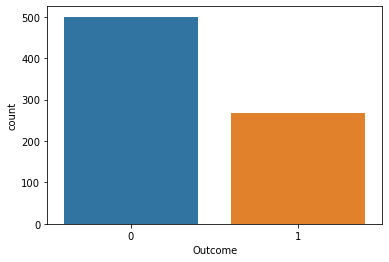

In [7]:
sns.countplot(x='Outcome', data=diabetes)

The target distribution is very unbalanced with two times more negative than positives.

### Heatmap Correlation

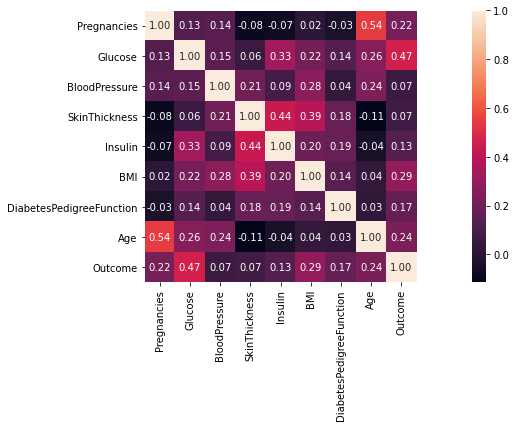

In [8]:
plt.figure(figsize=(20, 5))
sns.heatmap(diabetes.corr(), annot=True, square=True, fmt='0.2f')

The glucose level, BMI, age and number of pregnancies are highly correlated with the outcome.<br>
Suprisingly, the insulin level is not very correlated with the outcome.<br>
Most likely because the insulin is correlated with the glucose and the glucose has 0.47 correlation with the target.

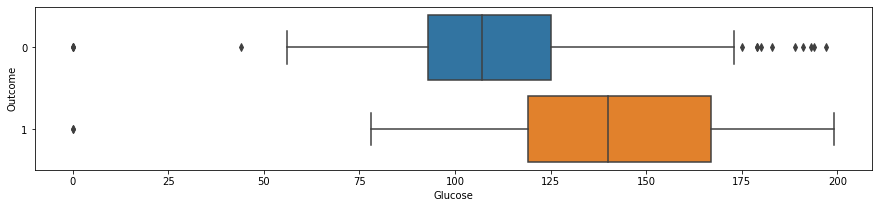

In [9]:
plt.figure(figsize=(15, 3))
sns.boxplot(x='Glucose', y='Outcome', orient='h', data=diabetes)

For patient with diabetes, the glucose level is significantly higher.<br>
In other words, a patient with high glucose level is very likely to have diabetes.

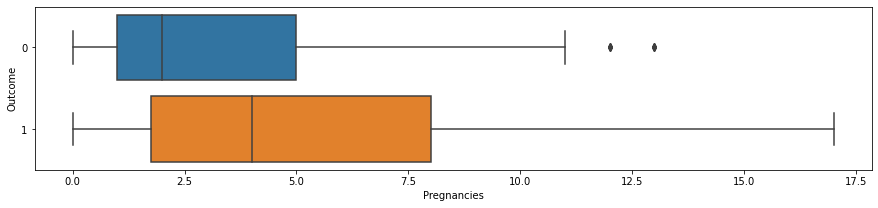

In [10]:
plt.figure(figsize=(15, 3))
sns.boxplot(x='Pregnancies', y='Outcome', orient='h', data=diabetes)

Surprisingly, the number of pregnancies is correlated with diabetes.

### Convert data to Torch tensors

In [11]:
X = diabetes.iloc[:, :-1].values
y = torch.from_numpy(diabetes.iloc[:, -1].values).float().unsqueeze(1)

In [12]:
# Standardize the data
X = StandardScaler().fit_transform(X)
X = torch.from_numpy(X).float()

# Add column of ones for the bias
ones_col = torch.ones((X.shape[0], 1), dtype=torch.float32)
X = torch.cat([ones_col, X], axis=1)

### Split data into train and test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

### Train Logistic Regression
The prediction of a logistic model is as follow:
$$
    \large \hat{y} = \sigma(\boldsymbol{X}\boldsymbol{w})
$$
Where $\sigma$ is the sigmoid or logit function:
$$
    \large \sigma(\boldsymbol{x}) = \frac{1}{1 + \exp(-x)}
$$<br>
The prediction $\hat{y}$ is obtained by matrix multiplication between the input $\boldsymbol{X}$ and the weights of the model $\boldsymbol{w}$ given as input to the logit function.<br/>
The sigmoid function is used here because it squashes the input in the $[0, 1]$ range suitable for describing a Bernouilli distribution.<br>
Where the Bernouilli cases are:
- the patient has diabetes with $p$ probability
- the patient does not have diabetes with $1 - p$ probability<br>

It is important to note that the bias is included in $\boldsymbol{X}$ as a column of ones.<br>

Training a classification model can be expressed as maximizing the likelihood of the observed data.<br>
In other words, we want the predicted probability of our model that a patient has diabetes to be as close as the true probability of the data.<br>
In practice, maximizing the likelihood is equivalent to minimize the negative log likelihood:<br>
$$
    \large L(\boldsymbol{\theta}) = - \frac{1}{N}\sum_{i=1}^{n}\boldsymbol{y_i}\log(\hat{\boldsymbol{y}}_i)
$$<br>
Because we dealing with a binary target, it is appropriate to use the binary cross entropy:<br>
$$
    \large L(\boldsymbol{\theta}) = - \frac{1}{N}\sum_{i=1}^{n}\boldsymbol{y_i}\log(\hat{\boldsymbol{y}}_i) + (1 - \boldsymbol{y_i})\log(1 - \hat{\boldsymbol{y}}_i)
$$

### Gradient Descent for Logistic Regression
We will use Gradient Descent to train the logistic regression model.<br>
 The Gradient descent method takes steps proportional to the negative of the gradient of a function at a given point, in order to iteratively minimize the objective function.<br> The gradient generalizes the notion of derivative to the case where the derivative is with respect to a vector: the gradient of $f$ is the vector containing all of the partial derivatives, denoted $\nabla_{\boldsymbol{x}}f(\boldsymbol{x})$.<br>
 
 The directional derivative in direction $\boldsymbol{u}$ (a unit vector) is the slope of the function $f$ in direction $\boldsymbol{u}$. In other words, the directional derivative is the derivative of the function $f(\boldsymbol{x} + \sigma \boldsymbol{u})$ with respect to $\sigma$ close to 0. To minimize $f$, we would like to find the direction in which $f$ decreases the fastest. We can do this using the directional derivative:
$$
    \large \min_{\boldsymbol{u}, \boldsymbol{u}^\top \boldsymbol{u} = 1}{\boldsymbol{u}^\top \nabla_{\boldsymbol{x}} f(\boldsymbol{x})}
$$<br>
$$    \large = \min_{\boldsymbol{u}, \boldsymbol{u}^\top \boldsymbol{u} = 1}{||\boldsymbol{u}||_2 ||\nabla_{\boldsymbol{x}}f(\boldsymbol{x})||_2 \cos \theta}$$<br>
ignoring factors that do not depend on $\boldsymbol{u}$, this simplifies to $\min_{u}{\cos \theta}$. This is minimized when $\boldsymbol{u}$ points in the opposite direction as the gradient. Each step of the gradient descent method proposes a new point:
$$
    \large \boldsymbol{x'} = \boldsymbol{x} - \epsilon \nabla_{\boldsymbol{x}}f(\boldsymbol{x})
$$<br>
where $\epsilon$ is the learning rate.<br>
In the context of logistic regression, the gradient descent is as follow:
$$
    \large \boldsymbol{w} = \boldsymbol{w} - \epsilon \nabla_{\boldsymbol{w}}L(\boldsymbol{\theta})
$$<br>
where:
$$
    \large \nabla_{\boldsymbol{w}}L(\boldsymbol{\theta}) = \nabla_{\boldsymbol{w}}\left(-\frac{1}{N}\sum_{i=1}^{n}\boldsymbol{y_i}\log(\hat{\boldsymbol{y}}_i) + (1 - \boldsymbol{y_i})\log(1 - \hat{\boldsymbol{y}}_i)\right)
$$<br>
$$
    \large = \frac{1}{N}\boldsymbol{X}^\top(\sigma(\boldsymbol{X}\boldsymbol{w}) - \boldsymbol{y})
$$<br>
Here is a nice explanation of how to find the gradient of the binary cross entropy:<br>
https://www.youtube.com/watch?v=hWLdFMccpTY

In [13]:
def sigmoid(x):
    """Sigmoid function that squashes the input between 0 and 1"""
    return 1 / (1 + torch.exp(-x))

def predict(X, weights):
    """Pedicts the class given the data and the weights
    
    Args:
        X: A torch tensor for the input data.
        weights: A torch tensor for the parameters calculated during the training
            of the Logistic regression.
    """
    return sigmoid(X.mm(weights))

In [14]:
def binary_cross_entropy(y_true, y_pred):
    """Loss function for the training of the logistic regression
    
    We add an epsilon inside the log functions to avoid Nans.
    
    Args:
        y_true: A torch tensor for the labels of the data.
        y_pred: A torch tensor for the values predicted by the model.
    """
    fact = 1 / y_true.shape[0]
    return -fact * (y_true * torch.log(y_pred + 1e-10) + (1 - y_true) * torch.log(1 - y_pred + 1e-10 )).sum()

In [15]:
def train_logit_reg(X, y_true, weights, lr=0.001, it=2000):
    """Trains the logistic regression model
    
    Args:
        X: A torch tensor for the training data.
        y: A torch tensor for the labels of the data.
        weights: A torch tensor for the learning parameters of the model.
        lr: A scalar describing the learning rate for the gradient descent.
        it: A scalar for the number of steps in the gradient descent.
    """
    for _ in range(it):
        y_pred = predict(X, weights)
        err = (y_pred - y_true)
        grad = X.T.mm(err)
        weights -= lr * grad
    bn_train = binary_cross_entropy(y_true, y_pred).item()
    return weights, bn_train

In [16]:
# Training the model
weights = torch.ones((X.shape[1], 1), dtype=torch.float32)
weights, bn_train = train_logit_reg(X_train, y_train, weights)
y_pred = predict(X_test, weights)
print('Binary cross-entropy on the train set:', bn_train)

Binary cross-entropy on the train set: 0.4595394730567932


### Binary cross entropy on test set

In [17]:
# Test the model
bn_test = binary_cross_entropy(y_test, y_pred).item()
print('Binary cross-entropy on the test set:', bn_test)

Binary cross-entropy on the test set: 0.5321948528289795


### Accuracy on test set
To compute the accuracy, we have to find the best threshold to convert our probability output in binary values.

In [18]:
def get_binary_pred(y_true, y_pred):
    """Finds the best threshold based on the prediction and the labels
    
    Args:
        y_true: A torch tensor for the labels of the data.
        y_pred: A torch tensor for the values predicted by the model.
    """
    y_pred_thr = y_pred.clone()
    
    accs = []
    thrs = []
    for thr in np.arange(0, 1, 0.01):
        y_pred_thr[y_pred >= thr] = 1
        y_pred_thr[y_pred < thr] = 0
        cur_acc = classification_report(y_test, y_pred_thr, output_dict=True)['accuracy']
        accs.append(cur_acc)
        thrs.append(thr)
    accs = torch.FloatTensor(accs)
    thrs = torch.FloatTensor(thrs)
    idx = accs.argmax()
    best_thr = thrs[idx].item()
    best_acc = accs[idx].item()
    y_pred[y_pred >= best_thr] = 1
    y_pred[y_pred < best_thr] = 0
    return y_pred

In [20]:
import sklearn
y_pred = get_binary_pred(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       123
         1.0       0.76      0.57      0.65        69

    accuracy                           0.78       192
   macro avg       0.78      0.73      0.75       192
weighted avg       0.78      0.78      0.77       192

[[111  12]
 [ 30  39]]


With a threshold of 0.66, we achieve an accuracy of 78% which is quite good for a linear model.

### Polynomial Logistic Regression
In this section, we will add some polynomial features to the logistic regressor.
It is the same principle as the logistic regression except that $\boldsymbol{X}$ is the concatenation of $\boldsymbol{X_1} \dots \boldsymbol{X_m}$ where $m$ is the degree of the polynomial function and $\boldsymbol{w}$ is the concatenation of $\boldsymbol{w_1} \dots \boldsymbol{w_m}$ such as:
$$
    \large \boldsymbol{y} = \sigma(\boldsymbol{w}_0 + \boldsymbol{X}\boldsymbol{w}_1 + \boldsymbol{X}^2\boldsymbol{w}_2 + \dots + \boldsymbol{X}^m\boldsymbol{w}_m)
$$<br>
This method is still linear because predicting $\hat{y} = \sigma(\boldsymbol{X}\boldsymbol{w})$ is still linear in the parameters.

In [21]:
X = torch.from_numpy(diabetes.iloc[:, :-1].values).float()
y = torch.from_numpy(diabetes.iloc[:, -1].values).float().unsqueeze(1)

In [14]:
def create_poly_features(X, degree=2):
    """Creates the augmented features for the polynomial model
    
    This function concatenates the augmented data into a single torch tensor.
    
    Args:
        X: A torch tensor for the data.
        degree: A integer for the degree of the polynomial function that we model.
    """
    if len(X.shape) == 1:
        X = X.unsqueeze(1)
    ones_col = torch.ones((X.shape[0], 1))
    # Standardize the output to avoid exploding gradients
    X_cat = X.clone()
    X_cat = (X_cat - X_cat.mean()) / X_cat.std()
    X_cat = torch.cat([ones_col, X_cat], axis=1)
    for i in range(1, degree):
        X_p = X.pow(i + 1)
        X_p = torch.from_numpy(StandardScaler().fit_transform(X_p)).float()
        X_cat = torch.cat([X_cat, X_p], axis=1)
    return X_cat

In [23]:
features = create_poly_features(X, degree=2)

In [24]:
def create_weights(features):
    """Creates a column of ones"""
    return torch.ones((features.shape[1], 1), dtype=torch.float32)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=42, test_size=0.25)

In [26]:
weights = create_weights(X_train)
weights, bn_train = train_logit_reg(X_train, y_train, weights, it=10000)
y_pred = predict(X_test, weights)
print('Binary cross-entropy on the train set:', bn_train)

Binary cross-entropy on the train set: 0.44449102878570557


In [27]:
binary_cross_entropy(y_test, y_pred).item()

0.5331151485443115

In [29]:
y_pred = get_binary_pred(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84       123
         1.0       0.84      0.45      0.58        69

    accuracy                           0.77       192
   macro avg       0.80      0.70      0.71       192
weighted avg       0.78      0.77      0.75       192

[[117   6]
 [ 38  31]]


### Conclusion
The polynomial logistic regression model overfitted compared to the classic logistic regression model because it lost 1% accuracy on the test set.<br>
For some very highly correlated data, logistic regression without polynomial features has better performance than with polynomial features.<br>
Logistic regression is a very simple and interpretable model suited as a baseline in most classification problems.<br>
However, it does not perform well when the feature space is large. In fact, it is difficult to compute feature transformation (such as polynomials) when the data doesn't fit in ram.<br>